### Predicting Customer Lifetime Value

We have three datasets here:
- customer ID dataset
- order dataset containing customer and order ID with the order timestamp
- payments dataset with the order ID and order value

We will join these datasets together to have all relevant info in one table, and get working!

In [18]:
# Importing libraries and packages 
import pandas as pd
import numpy as np
import seaborn as sns
import lifetimes
from lifetimes import ModifiedBetaGeoFitter
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [53]:
np.random.seed(42)

import random
random.seed(42)

In [54]:
# Read in the data
df1 = pd.read_csv('olist_orders_dataset.csv')
df2 = pd.read_csv('olist_customers_dataset.csv')
df3 = pd.read_csv('olist_order_payments_dataset.csv')

# Cleaning orders dataframe
cols = ['customer_id', 'order_id', 'order_purchase_timestamp']
orders = df1[cols]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

# The same with payments dataframe 
cols = ['order_id', 'payment_value']
payments = df3[cols]
payments = payments.set_index('order_id')
payments = payments.drop_duplicates()

# ...and with the customers dataframe
cols = ['customer_id', 'customer_unique_id']
customers = df2[cols]
customers = customers.set_index('customer_id')

In [64]:
# Inner join our customers and orders table 
order_log = pd.concat([orders,customers], axis=1, join='inner')
order_log.reset_index(inplace=True)

# Extract the order date from the order timestamp column
order_log['order_purchase_timestamp'] = pd.to_datetime(order_log['order_purchase_timestamp'])
order_log['order_date'] = order_log.order_purchase_timestamp.dt.date
order_log['order_date'] = pd.to_datetime(order_log['order_date'])

# Retain only the relevant columns
cols = ['customer_id', 'order_date']
order_log = order_log[cols]

order_log.info()
order_log.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  99441 non-null  object        
 1   order_date   99441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,customer_id,order_date
0,9ef432eb6251297304e76186b10a928d,2017-10-02
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08
3,f88197465ea7920adcdbec7375364d82,2017-11-18
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13


In [65]:
# Returning the data-range of our data

order_log.order_date.describe()

count                   99441
unique                    634
top       2017-11-24 00:00:00
freq                     1176
first     2016-09-04 00:00:00
last      2018-10-17 00:00:00
Name: order_date, dtype: object

We now have a dataset with the unique customer ID, and the order date. We know that the date range of this dataset is between 4th Sep 2016 and 17th Oct 2018.

#### Creating a Recency, Frequency, Monetary (RFM) Matrix based on our transaction log

The RFM matrix is created using the following components:
- Recency (R): The time since the customer's last transaction or purchase i.e. how recently a customer has interacted with the business. Generally, customers who have made more recent purchases are considered more engaged and potentially more valuable.

- Frequency (F): The no. of transactions or purchases made by a customer within a specific period. It reflects the customer's purchasing behavior and loyalty. Customers with higher frequency are often considered more valuable as they make repeated purchases.

- Monetary value (M): The total $ value or revenue generated by a customer within a specific period. It indicates the customer's spending power and contribution to the business.

The transaction log data is analyzed to calculate these three metrics for each customer. Each customer is then assigned a value or score for each of the RFM components based on their behavior.

Note: the calibration period is the initial time period used for model estimation, where historical data is used to estimate the parameters of the CLV model. The holdout period is a separate time period that follows the calibration period, used for evaluating and validating the model's predictive accuracy by comparing the model's predictions against actual customer behavior. 

In [66]:
order_log

,customer_id,order_date
0,9ef432eb6251297304e76186b10a928d,2017-10-02
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08
3,f88197465ea7920adcdbec7375364d82,2017-11-18
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13
...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09
99437,1fca14ff2861355f6e5f14306ff977a7,2018-02-06
99438,1aa71eb042121263aafbe80c1b562c9c,2017-08-27
99439,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08


In [67]:
calibration_ends = '2018-06-30'

from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(order_log, 
                                                   customer_id_col = 'customer_id', 
                                                   datetime_col = 'order_date', 
                                                   freq = 'D', #days
                                        calibration_period_end=calibration_ends,
                                        observation_period_end='2018-09-28' )




In [68]:
summary_cal_holdout.frequency_cal.nunique()

1

In [69]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
00012a2ce6f8dcda20d059ce98491703,0.0,0.0,228.0,0.0,90.0
000161a058600d5901f007fab4c27140,0.0,0.0,349.0,0.0,90.0
0001fd6190edaaf884bcaf3d49edf079,0.0,0.0,487.0,0.0,90.0
0002414f95344307404f0ace7a26f1d5,0.0,0.0,318.0,0.0,90.0
000379cdec625522490c315e70c7a9fb,0.0,0.0,89.0,0.0,90.0
...,...,...,...,...,...
fffecc9f79fd8c764f843e9951b11341,0.0,0.0,93.0,0.0,90.0
fffeda5b6d849fbd39689bb92087f431,0.0,0.0,39.0,0.0,90.0
ffff42319e9b2d713724ae527742af25,0.0,0.0,17.0,0.0,90.0


The MBG/NBD model is a commonly used probabilistic model in customer analytics for estimating customer lifetime value (CLV) and predicting customer behavior. An overview of the assumptions and characteristics of the MBG/NBD model:

- Transaction Process: the number of transactions made by a customer while they are active follows a Poisson process with a transaction rate λ i.e. the timing of customer transactions follows a random, memoryless process.

- Heterogeneity in Transaction Rate: the model accounts for heterogeneity in transaction rates across customers. It assumes that the distribution of transaction rates across customers follows a Gamma distribution - this means that different customers have different transaction rates, capturing the natural variation in customer behavior.

- Inactivity or Dropout: customers become inactive or "drop out" after making a transaction with a constant probability p. Inactivity implies that the customer does not make any further transactions after a certain point in time.

- Heterogeneity in Dropout Probability: Similar to transaction rates, the model also considers heterogeneity in the dropout probability across customers. It assumes that the distribution of dropout probabilities across customers follows a Gamma distribution with parameters a and b. This captures the variation in the likelihood of customers becoming inactive.

- Independence of Transaction Rate and Dropout Probability: the transaction rate λ and the dropout probability p are independent of each other across customers. This means that the two characteristics vary independently, allowing for different patterns of customer behavior.

In [26]:
mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['time_cal'],
       verbose=True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


<lifetimes.ModifiedBetaGeoFitter: fitted with 86617 subjects, a: 0.00, alpha: 0.47, b: 0.00, r: 0.00>

In [27]:
print(mbgnbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 86617 subjects, a: 0.00, alpha: 0.47, b: 0.00, r: 0.00>


In [28]:
t = 90 # days to predict in the future 
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      summary_cal_holdout['frequency_cal'], 
                                                                                      summary_cal_holdout['recency_cal'], 
                                                                                      summary_cal_holdout['time_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'], 
                                                                         summary_cal_holdout['recency_cal'], 
                                                                         summary_cal_holdout['time_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)

In [29]:
display(summary_cal_holdout.sample(2).T)

customer_id,d052dd92c5be64d0b7ead6ee23dad19d,87013b240790484b45271bfb0eb96904
frequency_cal,0.000000e+00,0.000000e+00
recency_cal,0.000000e+00,0.000000e+00
time_cal,1.230000e+02,4.700000e+01
frequency_holdout,0.000000e+00,0.000000e+00
duration_holdout,9.000000e+01,9.000000e+01
predicted_purchases,2.684382e-25,6.990024e-25
p_alive,1.000000e+00,1.000000e+00


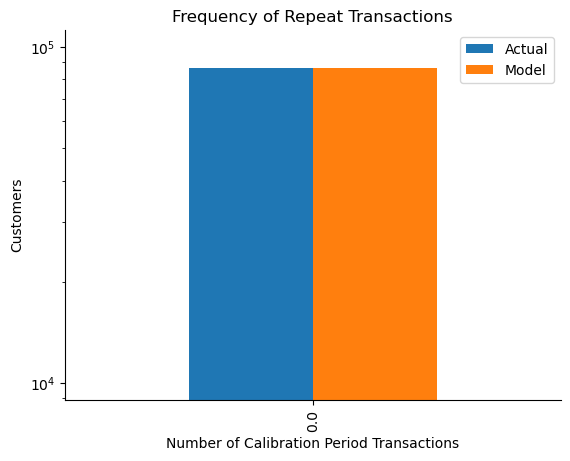

In [30]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();